**Importing Libraries**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime

In [ ]:
#loading the data
covid_df = pd.read_csv("covid_19_india.csv",parse_dates=True)
#dropping undesired columns
covid_df.drop(["Sno","Time","ConfirmedIndianNational","ConfirmedForeignNational"],inplace = True,axis =1)

In [ ]:
#changing statewise data to countrywise
statewise = pd.pivot_table(covid_df,values = ["Confirmed","Deaths","Cured"],index = "Date",aggfunc = max)
df = pd.DataFrame(data=statewise)
covid_df = df

In [ ]:
#Active Cases
covid_df['Active']=covid_df['Confirmed'] - (covid_df['Cured'] + covid_df['Deaths'])
covid_df

,Confirmed,Cured,Deaths,Active
Date,,,,
2020-01-30,1,0,0,1
2020-01-31,1,0,0,1
2020-02-01,2,0,0,2
2020-02-02,3,0,0,3
2020-02-03,3,0,0,3
...,...,...,...,...
2021-08-07,6341759,6130137,133717,77905
2021-08-08,6347820,6139493,133845,74482
2021-08-09,6353328,6144388,133996,74944


In [ ]:
covid_df = covid_df.iloc[62:337]
covid_df

,Confirmed,Cured,Deaths,Active
Date,,,,
2020-04-01,302,39,9,254
2020-04-02,335,42,13,280
2020-04-03,335,42,16,277
2020-04-04,490,42,24,424
2020-04-05,503,49,24,430
...,...,...,...,...
2020-12-27,1916236,1807824,49189,59223
2020-12-28,1919550,1809948,49255,60347
2020-12-29,1922048,1814449,49305,58294


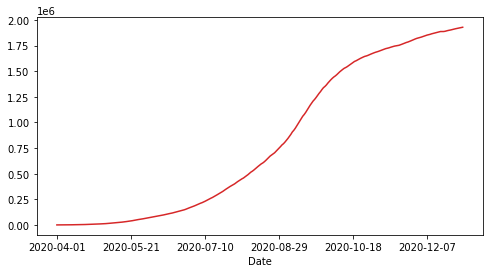

In [ ]:
covid_df["Confirmed"].plot(figsize=(8,4), color="tab:red");

**Strengths of Bayesian Statistics**
1.Great flexibility to quickly and iteratively build statistical models
2.Offers principled way of dealing with uncertanity
3.Don't just want most likely outcome but distribution of all possible outcomes
4.Allows expert inforation to guide model by using informative priors

**Importing Necessary Libraries for Bayesian**

In [ ]:
!pip install pymc3
import pymc3 as pm
import arviz as az
import seaborn as sns
from IPython.display import display , Markdown
import warnings
warnings.simplefilter("ignore")

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

sampler_kwargs = {"chains" : 4,"cores":4,"return_inferencedata":True}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 4.3 MB/s 
     |████████████████████████████████| 1.8 MB 11.4 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=14d03c6e8e348ad353c847f237f03bd4f8c7aa2e732c76a392192e0f97a4d679
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc


**Removing the data for below 100 days**
  After loading data , first we will remove any days where confirmed cases was below 100(as reporting is often very noisy in this time-frame).

In [ ]:
coviddata = pd.read_csv("coviddata.csv")
coviddata = coviddata.loc[lambda x: (x.Confirmed >=100)]
coviddata.head()

,Date,Active,Confirmed,Cured,Deaths,days_since_100
55,3/25/2020,114,128,11,3,0
56,3/26/2020,110,124,11,3,1
57,3/27/2020,118,137,15,4,2
58,3/28/2020,150,180,25,5,3
59,3/29/2020,155,186,25,6,4


**Flow of Work**
1. Plot the data
2. Build Model
3. Run prior predictive check
4.Fit Model
5.Assess Convergence
6.Run Posterior Check
7.Improve Model

(Here we will analyse the data for the first 30 days and then will look later for full data.)

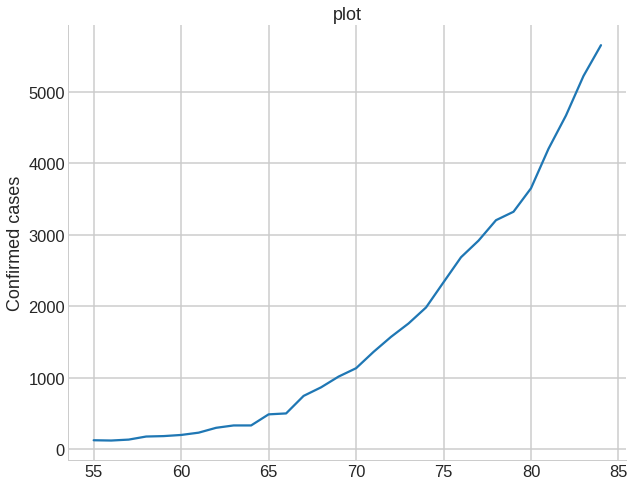

In [ ]:
df_country = coviddata.iloc[:30]

fig, ax=plt.subplots(figsize=(10,8))
df_country.Confirmed.plot(ax=ax)
ax.set(ylabel='Confirmed cases',title = "plot")
sns.despine()

**Build Model**
1. **The above line looks like an exponential . This matches with knowledge from epidemiology whereas early in an epidemic it grows exponentially.**

In [ ]:
#Get time-range of days since 100 cases were crossed
t = df_country.days_since_100.values
#get number of confirmed cases
confirmed = df_country.Confirmed.values

with pm.Model() as model_exp1:
  #Intercept
  a = pm.Normal('a',mu=0,sigma=100)

  #slope
  b = pm.Normal('b',mu=0.3,sigma=0.3)

  #Exponential regression
  growth = a * (1+b) ** t

  #Error term
  eps = pm.HalfNormal('eps',100)

  #Likelihood
  pm.Normal('obs',mu=growth,sigma=eps,observed=confirmed)

In [ ]:
with model_exp1:
  prior_pred = pm.sample_prior_predictive()

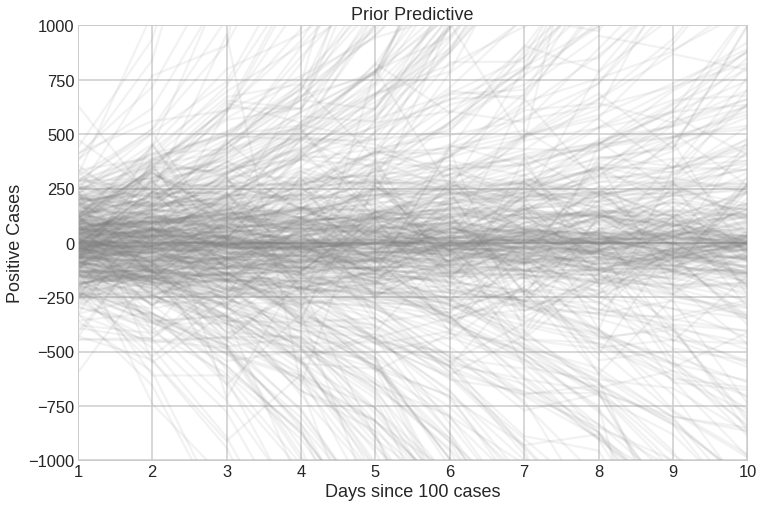

In [ ]:
fig,ax=plt.subplots(figsize=(12,8))
ax.plot(prior_pred['obs'].T,color="0.5",alpha=.1)
ax.set(ylim=(-1000,1000),
       xlim=(1,10),
       title="Prior Predictive",
       xlabel="Days since 100 cases",
       ylabel="Positive Cases");

In [ ]:
with model_exp1:
  trace = pm.sample(**sampler_kwargs)

ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
with model_exp1:
  trace = pm.sample(tune=0,draws=500,return_inferencedata=True)

ERROR:pymc3:The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc3:The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


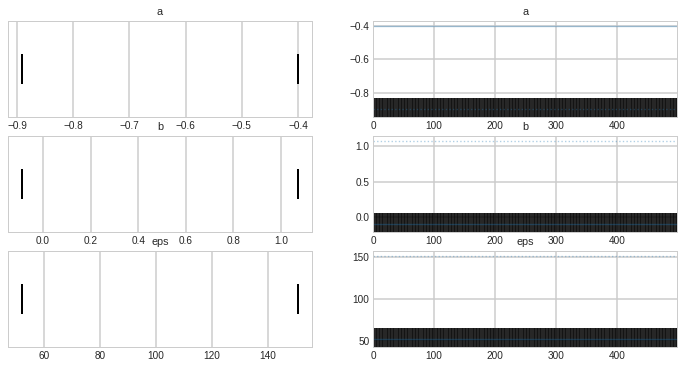

In [ ]:
az.plot_trace(trace);

In [ ]:
t = df_country.days_since_100.values

confirmed = df_country.Confirmed.values

with pm.Model() as model_exp2:
  #Intercept
  a = pm.Normal('a',mu=100,sigma=25)

  #slope
  b = pm.Normal('b',mu=0.3,sigma=0.1)

  #Exponential regression
  growth = a * (1+b) ** t

  #Error term
  eps = pm.HalfNormal('eps',100)

  #Likelihood
  pm.NegativeBinomial('obs',mu=growth,alpha=pm.Gamma("alpha",mu=6,sigma=1),observed=confirmed)

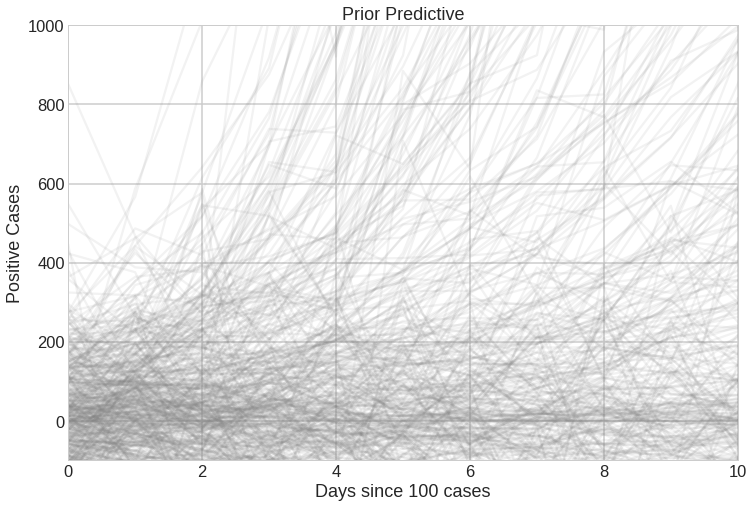

In [ ]:
with model_exp1:
  prior_pred = pm.sample_prior_predictive()

fig,ax=plt.subplots(figsize=(12,8))
ax.plot(prior_pred['obs'].T,color="0.5",alpha=.1)
ax.set(ylim=(-100,1000),
       xlim=(0,10),
       title="Prior Predictive",
       xlabel="Days since 100 cases",
       ylabel="Positive Cases");


**4.Fit Model**

In [ ]:
with model_exp2:
  trace_exp2 = pm.sample(**sampler_kwargs)

ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


**5.Assess convergence**

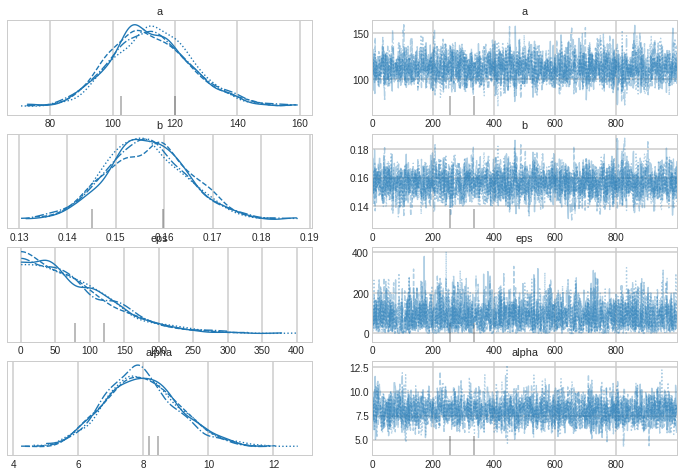

In [ ]:
az.plot_trace(trace_exp2);

In [ ]:
az.summary(trace_exp2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,112.474,12.838,90.408,138.664,0.312,0.222,1707.0,1592.0,1.0
b,0.156,0.008,0.141,0.173,0.000,0.000,1954.0,1891.0,1.0
eps,79.558,60.714,0.019,189.764,1.356,0.959,1276.0,964.0,1.0
alpha,7.961,1.128,5.742,9.992,0.025,0.017,2086.0,2331.0,1.0


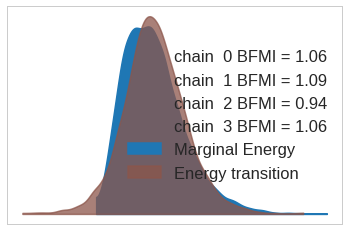

In [ ]:
az.plot_energy(trace_exp2);

**6.Run posterior predictive check**

In [ ]:
with model_exp2:
  #Draw samples from posterior predictive
  post_pred = pm.sample_posterior_predictive(trace_exp2.posterior)

In [ ]:
fig,ax=plt.subplots(figsize=(10,8))
ax.plot(post_pred['obs'].T,color="0.5",alpha=.05)
ax.plot(confirmed,color='r',label='data')
ax.set(xlabel="Days since 100 cases",
       ylabel="Confirmed cases (log scale)",
       ylim=(0,100_000),title="Graph",
       yscale="log");

In [ ]:
fig,ax = plt.subplots(figsize=(10,8))
resid = post_pred["obs"] - confirmed
ax.plot(resid.T,color="0.5",alpha=.01);
ax.set(ylim=(-50_000,200_000),ylabel="Residual",
       xlabel="days since 100 cases");

**Prediction and forecasting**

In [ ]:
with pm.Model() as model_exp3:
  #pm.Data needs to be in the model context so that we can
  #keep track of it.
  #Then, we can use it like any other array.
  t_data = pm.Data('t',df_country.days_since_100.values)
  confirmed_data = pm.Data('Confirmed',df_country.Confirmed.values)

  #Intercept
  BoundNormal_100 = pm.Bound(pm.Normal,lower=100)
  a= BoundNormal_100('a',mu=100,sigma=25)

  #slope
  BoundNormal_0 = pm.Bound(pm.Normal,lower=0)
  b=BoundNormal_0('b',mu=0.3,sigma=0.1)

  #Exponential Regression
  growth = a* (1+b) ** t_data

  #Likelihood
  pm.NegativeBinomial('obs',
                      growth,
                      alpha=pm.Gamma('alpha',mu=6,sigma=1),
                      observed = confirmed_data)
  trace_exp3 = pm.sample(**sampler_kwargs)



In [ ]:
with model_exp3:
  #update our data containers.
  #Note that because confirmed it observed, we do not need to specify any data
  #as that is only needed
  #during inference.But do have to update it to match
  #the shape.
  pm.set_data({'t': np.arange(60),
               'Confirmed':np.zeros(60,dtype='int')})

  post_pred = pm.sample_posterior_predictive(trace_exp3.posterior)


**7.Improve Model**

**Logistic Model**

In [ ]:
with pm.Model() as logistic_model:

  t_data = pm.Data('t',df_country.days_since_100.values)
  confirmed_data = pm.Data('Confirmed',df_country.Confirmed.values)

  #Intercept
  BoundNormal_100 = pm.Bound(pm.Normal,lower=100)
  intercept= BoundNormal_100('a',mu=100,sigma=25)

  #slope
  BoundNormal_0 = pm.Bound(pm.Normal,lower=0)
  b = BoundNormal_0('b',mu=0.3,sigma=0.1)

  carrying_capacity = pm.Uniform('carrying_capacity',
                                 lower=1_000,
                                 upper=80_000_000)

  #Transform carrying capacity to a
  a = carrying_capacity / intercept -1


  #Logistic
  growth = carrying_capacity / (1+a * pm.math.exp(-b * t_data))

  #Likelihood
  pm.NegativeBinomial('obs',
                      growth,
                      alpha=pm.Gamma('alpha',mu=6,sigma=1),
                      observed = confirmed_data)
  prior_pred = pm.sample_prior_predictive()

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(prior_pred['obs'].T,color="0.5",alpha=.1)
ax.set(title="Prior Predictive",
       xlabel="Days since 100 cases",
       ylabel="Positve Cases",
       yscale="log",
       );

In [ ]:
with logistic_model:
  #Inference
  trace_logistic = pm.sample(**sampler_kwargs,target_accept=0.9)

  #sample posterior predictive
  post_pred = pm.sample_posterior_predictive(trace_logistic.posterior)

In [ ]:
az.plot_trace(trace_logistic);

In [ ]:
fig , ax=plt.subplots(figsize=(10,8))
ax.plot(post_pred['obs'].T,color='0.5',alpha =.05)
ax.plot(df_country.Confirmed.values,color='r')
ax.set(xlabel='Days since 100 cases',ylabel='Confirmed cases',title='Graph');

**Model Comparison**

In [ ]:
with model_exp3:
  pm.set_data({"t":df_country.days_since_100.values,
               "Confirmed":df_country.Confirmed.values})
  trace_exp3_full = pm.sample(**sampler_kwargs)

In [ ]:
az.compare({"exp3":trace_exp3_full,
            "logistic":trace_logistic})

As we can see that logistic model provides a much better fit to the data.

**Generative Model**

Let's assume that for an idealized disease we start with a single infected patient(primary infection) on day 0 thatis infectious for a single day only and on that day goes on to infect 2 people(secondary infection) which become sick the next day. This disease thus has a reproduction factor Ro of 2. We could write thta on day t the number of newly infected Y(t)=Y(t-1).Ro

Quite simple.This logic gives rise to the classic exponential growth pattern we see in epidemics:

In [ ]:
n_days = 10
ts = np.arange(n_days)
R0 = 2
y = np.zeros(n_days)

y[0]  = 1   #starting with 1 infected
for t in ts[1:]:
  y[t] = y[t-1] *  R0

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(ts,y);
ax.set(xlabel='time',ylabel='newly infected',
       title='Growth of idealized disease with $R_0 = 2$');
sns.despine();

**Building a Model**

In order to build this recursive nature into PyMC3 we need to loop inside our
model. Because PyMC3 compiles everything to theano we can't just use a python
loop. Fortunately, theano has its own looping logic in the form of scan.

In [ ]:
len_observed = len(new_cases)


In [ ]:
india_data = full_grouped[full_grouped['Country/Region'] == 'India']